In [1]:
"""Example of the optimization process for SGOOP.  Here we find the weights of cos(phi),sin(phi),cos(psi),sin(psi)
for alanine dipeptide in vacuum from an unbiased trajectory.  We use the cos and sin of dihedral angles to avoid
inaccuracy caused by the discontinuity of angles (pi = -pi)."""
import sgoop
import scipy.optimize as opt
import numpy as np
import time
import matplotlib.pyplot as plt
import kinetics as kin

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [2]:
def opti_func(rc):
    # function to be used in basinhopping. records function evaluations and returns -spectral gap
    global nfev
    nfev +=1
    return -sgoop.rc_eval(rc)

In [3]:
def biased_opti_func(rc,old_rc):
    # multidimensional equivalent of the optimization function
    global nfev
    nfev +=1
    return -sgoop.biased_eval(rc,old_rc)

In [4]:
def print_fun(x, f, accepted):
    # printing progress during optimization
    global now,last,nfev,lastf
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

In [5]:
def temp_print_fun(x, f, accepted):
    # printing progress while determining the temperature
    global now,last,nfev,lastf,f_array,f_i
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev
    f_array[f_i]=-f
    f_i+=1

In [6]:
def sgoophopping(step=1,iterations=3):
    # basinhopping for 1 dimensional SGOOP
    global last,nfev,lastf,f_array,f_i
    
    f_array=np.zeros(50)
    f_i=0

    print('---------------------------------------------------------------------------')
    print('BEGINNING',sgoop.wells,'WELL TEMPERATURE OPTIMIZATION')
    print('---------------------------------------------------------------------------')

    # Finding temperature value
    start = time.time()
    last = start
    lastf = nfev = 0
    minimizer_kwargs = {"options": {"maxiter":10}}
    ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=50,T=.01,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=temp_print_fun)
    T_new=np.mean(np.abs(f_array[0:-1]-f_array[1:]))

    replicas=[None]*iterations

    for i in range(iterations):
        print('---------------------------------------------------------------------------')
        print('BEGINNING',sgoop.wells,'WELL RC OPTIMIZATION #',i+1)
        print('---------------------------------------------------------------------------')
        start = time.time()
        last = start
        lastf = nfev = 0
        minimizer_kwargs = {"options": {"maxiter":10}}
        ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=200,T=T_new,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
        replicas[i]=[ret.x,-ret.fun]

    replicas=np.asarray(replicas)
    soln=replicas[:,0][np.argmax(replicas[:,1])]
    soln/=soln[np.argmax(np.abs(soln))]
    p=sgoop.md_prob(soln)
    wells_found=kin.find_wells(p)
    return wells_found,soln

In [7]:
def biashopping(old_rc,step=1,iterations=3):
    # basinhopping for  multidimensional SGOOP
    global last,nfev,lastf,f_array,f_i
    
    f_array=np.zeros(50)
    f_i=0

    print('---------------------------------------------------------------------------')
    print('BEGINNING',sgoop.wells,'WELL TEMPERATURE OPTIMIZATION')
    print('---------------------------------------------------------------------------')

    # Finding temperature value
    start = time.time()
    last = start
    lastf = nfev = 0
    minimizer_kwargs = {"options": {"maxiter":10},"args":old_rc}
    ret = opt.basinhopping(biased_opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=50,T=.01,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=temp_print_fun)
    T_new=np.mean(np.abs(f_array[0:-1]-f_array[1:]))

    replicas=[None]*iterations

    for i in range(iterations):
        print('---------------------------------------------------------------------------')
        print('BEGINNING',sgoop.wells,'WELL RC OPTIMIZATION #',i+1)
        print('---------------------------------------------------------------------------')
        start = time.time()
        last = start
        lastf = nfev = 0
        minimizer_kwargs = {"options": {"maxiter":10},"args":old_rc}
        ret = opt.basinhopping(biased_opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=200,T=T_new,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
        replicas[i]=[ret.x,-ret.fun]
    
    replicas=np.asarray(replicas)
    soln=replicas[:,0][np.argmax(replicas[:,1])]
    soln/=soln[np.argmax(np.abs(soln))]
    p=sgoop.md_prob(soln)
    wells_found=kin.find_wells(p)
    return wells_found,soln

---------------------------------------------------------------------------
BEGINNING 2 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[-0.497 -0.176  0.281  1.009] with spectral gap 0.0000 declined after  12 runs (0.057)
[-0.424 -0.137 -0.103  0.685] with spectral gap 0.0385 declined after   6 runs (0.014)
[ 1.097 -0.132 -0.549  0.702] with spectral gap 0.0604 declined after   6 runs (0.013)
[ 0.217 -0.223 -0.492  0.947] with spectral gap 0.0219 declined after   6 runs (0.013)
[-0.885  0.371 -0.869  0.672] with spectral gap 0.0600 accepted after   6 runs (0.013)
[-1.348  0.606 -1.799  0.491] with spectral gap 0.0591 accepted after   6 runs (0.014)
[-0.378  1.421 -2.188  0.397] with spectral gap 0.0696 accepted after   6 runs (0.013)
[ 0.455  2.284 -1.649  1.215] with spectral gap 0.0757 accepted after   6 runs (0.014)
[ 1.141  2.011 -0.909  1.999] with spectral gap 0.0363 declined after   6 runs (0.013)
[ 1.060  2.732 -1.206  

[ 1.164  0.495 -0.087 -0.218] with spectral gap 0.0796 declined after   6 runs (0.013)
[ 1.698  0.604  0.120 -0.588] with spectral gap 0.0742 declined after   6 runs (0.013)
[ 2.045 -0.311 -0.094  0.403] with spectral gap 0.0700 declined after   6 runs (0.013)
[ 0.542 -0.021 -0.772  0.563] with spectral gap 0.0342 declined after   6 runs (0.013)
[ 0.856  0.466 -1.090  0.575] with spectral gap 0.0743 accepted after   6 runs (0.012)
[ 1.512  0.185 -0.507  0.128] with spectral gap 0.0612 declined after   6 runs (0.013)
[ 0.854  0.858 -0.294  0.221] with spectral gap 0.0434 declined after   6 runs (0.013)
[ 0.342  0.996 -1.504 -0.164] with spectral gap 0.0837 accepted after   6 runs (0.012)
[ 0.684  0.133 -0.762 -0.875] with spectral gap 0.0757 accepted after  42 runs (0.085)
[ 1.373  0.345 -0.817  0.019] with spectral gap 0.0723 declined after   6 runs (0.012)
[ 0.271  0.088 -1.418 -1.101] with spectral gap 0.0577 declined after   6 runs (0.012)
[-0.036 -0.237 -1.116 -0.264] with spectral

[-1.666  4.365 -5.050  0.783] with spectral gap 0.0652 accepted after   6 runs (0.013)
[-0.836  3.482 -5.131  1.155] with spectral gap 0.0696 accepted after   6 runs (0.012)
[-0.912  3.626 -5.098  1.120] with spectral gap 0.0701 accepted after   6 runs (0.012)
[-1.614  4.236 -5.061  1.236] with spectral gap 0.0659 accepted after   6 runs (0.012)
[-2.118  3.599 -5.123  2.073] with spectral gap 0.0641 accepted after   6 runs (0.013)
[-2.206  4.063 -4.405  1.944] with spectral gap 0.0631 declined after   6 runs (0.013)
[-1.287  2.977 -4.566  1.525] with spectral gap 0.0661 accepted after   6 runs (0.012)
[-1.973  3.340 -3.925  1.434] with spectral gap 0.0621 declined after   6 runs (0.012)
[-2.095  3.227 -4.045  1.027] with spectral gap 0.0593 accepted after   6 runs (0.012)
[-2.047  3.299 -4.005  0.332] with spectral gap 0.0593 accepted after   6 runs (0.012)
[-2.231  3.604 -4.053 -0.500] with spectral gap 0.0581 accepted after   6 runs (0.013)
[-2.266  3.793 -3.675  0.371] with spectral

[-4.345 -6.272 -6.689 -3.190] with spectral gap 0.0758 accepted after   6 runs (0.013)
[-4.915 -7.093 -7.237 -2.995] with spectral gap 0.0776 accepted after   6 runs (0.013)
[-5.875 -6.363 -7.115 -3.044] with spectral gap 0.0739 accepted after   6 runs (0.013)
[-5.399 -7.057 -7.707 -2.665] with spectral gap 0.0765 accepted after   6 runs (0.013)
[-5.558 -6.827 -6.794 -3.422] with spectral gap 0.0761 accepted after   6 runs (0.012)
[-5.045 -7.106 -6.684 -3.381] with spectral gap 0.0779 accepted after   6 runs (0.013)
[-5.556 -7.451 -6.046 -2.872] with spectral gap 0.0816 accepted after   6 runs (0.013)
[-4.942 -7.313 -6.843 -2.320] with spectral gap 0.0799 accepted after   6 runs (0.013)
[-5.592 -8.411 -6.000 -2.939] with spectral gap 0.0833 accepted after   6 runs (0.013)
[-4.875 -8.885 -6.985 -3.577] with spectral gap 0.0799 accepted after   6 runs (0.013)
[-4.038 -9.011 -7.453 -3.101] with spectral gap 0.0781 accepted after   6 runs (0.013)
[-3.690 -9.066 -8.511 -3.046] with spectral

[-1.690 -8.628 -6.258  3.048] with spectral gap 0.0341 accepted after   6 runs (0.015)
[-2.475 -9.414 -5.189  3.654] with spectral gap 0.0296 declined after   6 runs (0.014)
[-2.250 -8.265 -7.304  3.498] with spectral gap 0.0415 accepted after   6 runs (0.013)
[-3.255 -8.913 -6.549  4.020] with spectral gap 0.0404 accepted after   6 runs (0.013)
[-4.404 -8.570 -6.964  4.441] with spectral gap 0.0459 accepted after   6 runs (0.013)
[-3.776 -8.256 -8.031  5.066] with spectral gap 0.0444 accepted after   6 runs (0.014)
[-3.745 -8.813 -7.988  4.849] with spectral gap 0.0438 declined after   6 runs (0.013)
[-4.493 -7.613 -7.174  4.014] with spectral gap 0.0504 accepted after   6 runs (0.013)
[-3.395 -6.599 -6.405  3.307] with spectral gap 0.0492 accepted after   6 runs (0.013)
[-2.909 -7.836 -5.735  4.151] with spectral gap 0.0387 declined after   6 runs (0.013)
[-4.592 -5.456 -6.714  3.532] with spectral gap 0.0586 accepted after   6 runs (0.013)
[-5.288 -5.890 -8.050  4.096] with spectral

[-2.107 -2.693  4.417 -0.878] with spectral gap 0.0739 declined after   6 runs (0.013)
[-2.825 -0.735  3.360  0.681] with spectral gap 0.0852 declined after   6 runs (0.013)
[-3.157 -0.759  2.875 -0.056] with spectral gap 0.0257 declined after   6 runs (0.012)
[-2.921 -2.179  3.896 -0.164] with spectral gap 0.1088 accepted after   6 runs (0.012)
[-3.179 -2.004  3.060  0.569] with spectral gap 0.0868 accepted after   6 runs (0.012)
[-2.971 -1.977  3.285  0.586] with spectral gap 0.1203 accepted after   6 runs (0.013)
[-2.059 -1.078  3.037  0.054] with spectral gap 0.1122 declined after   6 runs (0.012)
[-2.716 -1.437  2.712 -0.009] with spectral gap 0.0693 declined after   6 runs (0.012)
[-3.603 -2.495  4.083  0.289] with spectral gap 0.1208 accepted after   6 runs (0.012)
[-4.323 -2.474  4.351  0.791] with spectral gap 0.0869 declined after   6 runs (0.012)
[-3.287 -3.096  4.032  1.090] with spectral gap 0.1044 declined after   6 runs (0.012)
[-4.053 -2.713  3.458  0.858] with spectral

[-4.296 -3.488  6.374 -1.589] with spectral gap 0.0923 accepted after   6 runs (0.014)
[-4.331 -3.033  5.546 -1.374] with spectral gap 0.1057 accepted after   6 runs (0.013)
[-4.569 -2.121  5.297 -1.149] with spectral gap 0.0776 accepted after   6 runs (0.013)
[-4.128 -1.375  4.220 -0.825] with spectral gap 0.0401 declined after   6 runs (0.013)
[-5.056 -1.094  4.221 -0.272] with spectral gap 0.0390 declined after   6 runs (0.013)
[-5.198 -3.192  5.103 -0.145] with spectral gap 0.0754 accepted after   6 runs (0.013)
[-4.854 -3.744  6.291 -1.088] with spectral gap 0.1060 accepted after   6 runs (0.013)
[-3.847 -3.026  6.911 -1.620] with spectral gap 0.0810 declined after   6 runs (0.013)
[-5.589 -3.713  6.268 -1.820] with spectral gap 0.0941 accepted after   6 runs (0.013)
[-5.889 -4.111  6.252 -2.837] with spectral gap 0.0738 declined after   6 runs (0.013)
[-4.744 -4.276  7.449 -2.706] with spectral gap 0.0787 declined after   6 runs (0.013)
[-6.066 -4.682  6.918 -1.388] with spectral

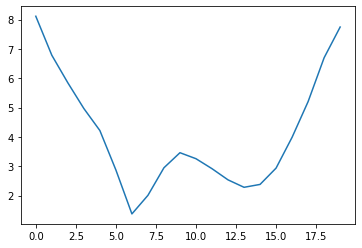

---------------------------------------------------------------------------
Optimized reaction coordinate: [-0.883 -0.611  1.000  0.071]
This solution has 2 wells and is therefore accepted.
---------------------------------------------------------------------------
---------------------------------------------------------------------------
BEGINNING 3 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[-0.676 -0.515  0.168 -0.577] with spectral gap 0.0343 accepted after  12 runs (0.026)
[-0.721 -0.948  1.055 -1.260] with spectral gap 0.0616 accepted after   6 runs (0.012)
[-1.263 -0.125  1.102 -1.444] with spectral gap 0.0554 accepted after   6 runs (0.012)
[-0.993  0.378  0.692 -0.899] with spectral gap 0.0397 accepted after   6 runs (0.013)
[-1.987 -0.240  1.272 -0.178] with spectral gap 0.0145 declined after   6 runs (0.012)
[-1.101 -0.589  0.427 -0.209] with spectral gap 0.0437 accepted after   6 runs (0.012)
[-1.924 -0.130  1.

[-3.429 -1.737  3.953  1.004] with spectral gap 0.0255 declined after   6 runs (0.014)
[-4.556 -2.388  4.294 -0.065] with spectral gap 0.0775 declined after   6 runs (0.013)
[-4.892 -1.337  4.313  1.184] with spectral gap 0.0918 accepted after   6 runs (0.014)
[-4.048 -1.329  4.424  0.359] with spectral gap 0.0809 declined after   6 runs (0.013)
[-4.457 -0.610  4.228  1.072] with spectral gap 0.0919 accepted after   6 runs (0.014)
[-4.367 -0.660  4.659  0.172] with spectral gap 0.1011 accepted after   6 runs (0.013)
[-3.811 -1.076  5.239  0.429] with spectral gap 0.0270 declined after   6 runs (0.013)
[-3.964 -1.411  3.851  0.703] with spectral gap 0.0909 declined after   6 runs (0.013)
[-5.222 -1.209  4.106  1.012] with spectral gap 0.0661 declined after   6 runs (0.013)
[-3.665 -0.844  5.363 -0.397] with spectral gap 0.0190 declined after   6 runs (0.013)
[-3.551 -1.306  4.584 -0.421] with spectral gap 0.0295 declined after   6 runs (0.013)
[-4.830 -1.015  4.375  0.613] with spectral

[-8.116 -2.157  6.750 -1.966] with spectral gap 0.0699 accepted after   6 runs (0.013)
[-8.375 -2.657  6.418 -2.799] with spectral gap 0.0606 declined after   6 runs (0.013)
[-7.775 -1.704  7.217 -2.169] with spectral gap 0.0860 accepted after   6 runs (0.013)
[-8.334 -2.579  6.907 -2.266] with spectral gap 0.0750 declined after   6 runs (0.013)
[-7.402 -2.517  7.325 -2.689] with spectral gap 0.0815 accepted after   6 runs (0.012)
[-7.812 -2.715  7.939 -2.257] with spectral gap 0.0848 accepted after   6 runs (0.012)
[-7.261 -3.478  7.257 -1.495] with spectral gap 0.0745 accepted after   6 runs (0.012)
[-7.338 -3.220  7.567 -0.836] with spectral gap 0.0742 accepted after   6 runs (0.012)
[-7.218 -3.848  6.878 -1.045] with spectral gap 0.0759 accepted after   6 runs (0.012)
[-6.376 -3.928  7.024 -0.797] with spectral gap 0.0311 declined after   6 runs (0.012)
[-7.127 -4.576  7.458 -1.846] with spectral gap 0.0361 declined after   6 runs (0.012)
[-6.327 -3.123  7.667 -1.834] with spectral

[ 1.098 -4.394  4.720  4.787] with spectral gap 0.0792 accepted after   6 runs (0.013)
[ 1.622 -3.951  5.465  3.793] with spectral gap 0.0795 accepted after   6 runs (0.013)
[ 0.803 -4.295  5.782  3.179] with spectral gap 0.0792 accepted after   6 runs (0.012)
[ 0.529 -4.030  4.787  2.628] with spectral gap 0.0809 accepted after   6 runs (0.012)
[ 0.179 -4.089  4.371  2.629] with spectral gap 0.0810 accepted after   6 runs (0.012)
[-0.631 -4.618  4.254  3.167] with spectral gap 0.0773 accepted after   6 runs (0.013)
[ 0.145 -4.790  4.200  3.865] with spectral gap 0.0800 accepted after   6 runs (0.012)
[ 1.158 -5.680  4.380  3.573] with spectral gap 0.0847 accepted after   6 runs (0.013)
[ 0.525 -6.144  5.314  4.643] with spectral gap 0.0808 declined after   6 runs (0.012)
[ 0.090 -5.695  4.861  4.616] with spectral gap 0.0796 accepted after   6 runs (0.012)
[-0.162 -5.156  5.124  5.470] with spectral gap 0.0778 accepted after   6 runs (0.012)
[-0.709 -4.850  4.970  5.546] with spectral

[-4.628  6.671  9.929  6.321] with spectral gap 0.0731 accepted after   6 runs (0.017)
[-4.708  7.906  11.029  7.609] with spectral gap 0.0733 accepted after   6 runs (0.014)
[-4.386  7.424  11.118  8.111] with spectral gap 0.0715 accepted after   6 runs (0.014)
[-3.237  7.368  11.611  7.490] with spectral gap 0.0683 declined after   6 runs (0.014)
[-3.449  7.163  10.085  9.176] with spectral gap 0.0736 accepted after   6 runs (0.014)
[-3.141  8.328  11.125  8.426] with spectral gap 0.0719 accepted after   6 runs (0.014)
[-2.763  8.575  11.944  8.059] with spectral gap 0.0695 accepted after   6 runs (0.013)
[-3.307  8.960  13.080  7.357] with spectral gap 0.0648 accepted after   6 runs (0.013)
[-3.605  7.984  14.062  6.742] with spectral gap 0.0571 accepted after   6 runs (0.013)
[-4.283  8.129  12.741  6.864] with spectral gap 0.0652 accepted after   6 runs (0.013)
[-3.072  9.028  12.857  6.900] with spectral gap 0.0633 accepted after   6 runs (0.013)
[-3.537  10.375  12.256  5.803] w

[ 6.965  0.745  2.044  2.485] with spectral gap 0.0758 accepted after   6 runs (0.018)
[ 7.782  1.520  2.938  1.715] with spectral gap 0.0748 accepted after   6 runs (0.014)
[ 8.602  1.248  3.834  2.408] with spectral gap 0.0783 accepted after   6 runs (0.018)
[ 9.087  1.160  3.985  3.113] with spectral gap 0.0757 accepted after   6 runs (0.013)
[ 8.266  1.084  3.450  3.616] with spectral gap 0.0785 accepted after   6 runs (0.013)
[ 7.648  0.725  2.791  3.471] with spectral gap 0.0776 accepted after   6 runs (0.012)
[ 7.239  1.247  3.157  2.491] with spectral gap 0.0762 accepted after   6 runs (0.012)
[ 6.224  1.252  2.105  2.726] with spectral gap 0.0799 accepted after   6 runs (0.012)
[ 5.171  1.588  2.372  3.516] with spectral gap 0.0728 accepted after   6 runs (0.013)
[ 4.440  1.665  1.528  3.621] with spectral gap 0.0605 accepted after   6 runs (0.015)
[ 3.742  2.375  1.815  3.398] with spectral gap 0.0556 accepted after   6 runs (0.013)
[ 4.181  1.517  2.648  2.932] with spectral

[ 3.900 -3.395 -1.601  1.195] with spectral gap 0.0327 declined after   6 runs (0.014)
[ 3.999 -5.216 -1.420  2.130] with spectral gap 0.0582 accepted after   6 runs (0.013)
[ 3.381 -5.151 -2.115  0.977] with spectral gap 0.0263 accepted after   6 runs (0.013)
[ 2.814 -3.970 -0.837 -0.173] with spectral gap 0.0691 accepted after   6 runs (0.013)
[ 1.544 -3.742 -1.302 -1.437] with spectral gap 0.0588 accepted after   6 runs (0.013)
[ 0.674 -3.623 -1.647 -0.166] with spectral gap 0.0479 declined after   6 runs (0.013)
[ 2.117 -4.801 -2.210 -2.269] with spectral gap 0.0829 accepted after   6 runs (0.013)
[ 2.089 -5.243 -3.528 -1.256] with spectral gap 0.0351 declined after   6 runs (0.013)
[ 2.652 -5.803 -2.102 -0.920] with spectral gap 0.0364 declined after   6 runs (0.013)
[ 2.253 -5.584 -1.986 -0.918] with spectral gap 0.0411 declined after   6 runs (0.012)
[ 2.462 -4.747 -2.762 -2.573] with spectral gap 0.0416 declined after   6 runs (0.013)
[ 1.868 -4.526 -3.357 -3.484] with spectral

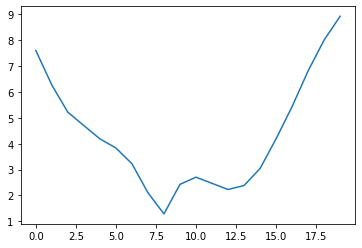

---------------------------------------------------------------------------
This solution has 1 wells and is therefore rejected.
---------------------------------------------------------------------------


In [8]:
sgoop.wells = 2
nfev=0
solutions=[]
wells_found,soln=sgoophopping(iterations=3) # calculating 2 well solution
p=sgoop.md_prob(soln)
plt.figure()
plt.plot(-np.ma.log(p))
plt.show()

while sgoop.wells == wells_found: # iteration for > 2 well solutions, continues while self consistent
    print('---------------------------------------------------------------------------')
    print('Optimized reaction coordinate:',soln)
    print('This solution has',wells_found,'wells and is therefore accepted.')
    print('---------------------------------------------------------------------------')
    solutions.append([soln,sgoop.wells])
    sgoop.wells+=1
    wells_found,soln=sgoophopping(iterations=3)
    p=sgoop.md_prob(soln)
    plt.figure()
    plt.plot(-np.ma.log(p))
    plt.show()
else:
    print('---------------------------------------------------------------------------')
    print('This solution has',wells_found,'wells and is therefore rejected.')
    print('---------------------------------------------------------------------------')

In [9]:
rc = solutions[-1][0]
std = np.std(np.dot(sgoop.data_array,rc))
print('Optimized RC:')
print(rc)
print('Standard deviation (sigma in metad):')
print(std)

Optimized RC:
[-0.883 -0.611  1.000  0.071]
Standard deviation (sigma in metad):
0.5141019194726142
